In [1]:
import pandas as pd
import numpy as np
import scipy.io
from IPython.display import Image
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp
plt.rcParams.update({'font.size': 14})
%matplotlib inline

In [2]:
def getTrainingPoints(df, n_points = 50):
    points = np.random.randint(0, len(df), n_points)
    training_points = df.iloc[points].values
    testing_points  = df.drop(points, axis = 0).values
    
    return training_points, testing_points

def gaussianProcess(X_train, y_train, X_test, y_test, kernel_name = 'RBF'):
    if kernel_name == 'RBF':
        kernel = gp.kernels.ConstantKernel(1.0, (1e-2, 1e4)) * gp.kernels.RBF(10.0, (1e-4, 1e4))
    elif kernel_name == 'Matern':
        kernel = gp.kernels.ConstantKernel(1.0, (1e-2, 1e4)) * gp.kernels.Matern(1.0, (1e-4, 1e4), nu = 1.5)
    elif kernel_name == 'Rational Quadratic':
        kernel = gp.kernels.RationalQuadratic(1.0, 1.0, (1e-4, 1e4), (1e-4, 1e4))
    elif kernel_name == 'Periodic':
        kernel = gp.kernels.ExpSineSquared(1.0, 1.0, (1e-4, 1e4), (1e-4, 1e4))
    elif kernel_name == 'DotProduct':
        kernel = gp.kernels.DotProduct(1.0, (1e-4, 1e4))
    else:
        print('Kernel not available! Please check kernel name. Using RBF as default/n')
        kernel = gp.kernels.ConstantKernel(1.0, (1e-2, 1e4)) * gp.kernels.RBF(10.0, (1e-4, 1e4))
        
    model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
    model.fit(X_train, y_train)
    params = model.kernel_.get_params()
    y_pred, std = model.predict(X_test, return_std=True)
    RMSE = np.sqrt(((y_pred-y_test)**2).sum()/len(y_test))
    
    return RMSE, params, y_pred, std

def add_colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

#### Import the data into a dataframe with columns X, Y, Z.
#### Select 50 training points at random and predict the rest. Calculate RMSE.

In [3]:
vec = scipy.io.loadmat('part_1_vec.mat')
arr = vec['xyz']
df = pd.DataFrame(arr, columns = ['X', 'Y','Z'])

training_points, testing_points = getTrainingPoints(df, 50)
X_train, y_train, X_test, y_test = training_points[:,:-1], training_points[:,-1], testing_points[:,:-1], testing_points[:,-1]

RMSE, params, y_pred, std = gaussianProcess(X_train, y_train, X_test, y_test, 'RBF')
print('RMSE = {:.2f}'.format(RMSE))
print('constant value = {:.2f}, length scale = {:.2f}'.format(params['k1__constant_value'], params['k2__length_scale']))

RMSE = 4.88
constant value = 60.34, length scale = 14.90


#### Some basic visualization - Actual and predicted data and training points selected.

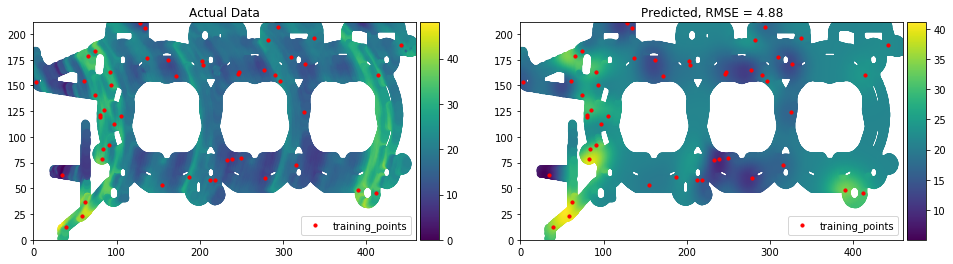

In [4]:
f, axarr = plt.subplots(1,2,figsize = (16,4))
ax1, ax2 = axarr[0], axarr[1]

z1 = ax1.scatter(X_test[:,0], X_test[:,1], c = y_test)
add_colorbar(z1)
ax1.scatter(training_points[:,0], training_points[:,1], color = 'red', s = 10, label = 'training_points')
ax1.set_xlim([0, df.X.max()])
ax1.set_ylim([0, df.Y.max()])
ax1.set_title('Actual Data')
ax1.legend()

z2 = ax2.scatter(X_test[:,0], X_test[:,1], c = y_pred)
add_colorbar(z2)
ax2.scatter(training_points[:,0], training_points[:,1], color = 'red', s = 10, label = 'training_points')
ax2.set_xlim([0, df.X.max()])
ax2.set_ylim([0, df.Y.max()])
ax2.set_title('Predicted, RMSE = {:.2f}'.format(RMSE))
ax2.legend()

plt.show()

#### Visualize the standard deviation in the GP prediction. The STDEV increases as we move away from training points.

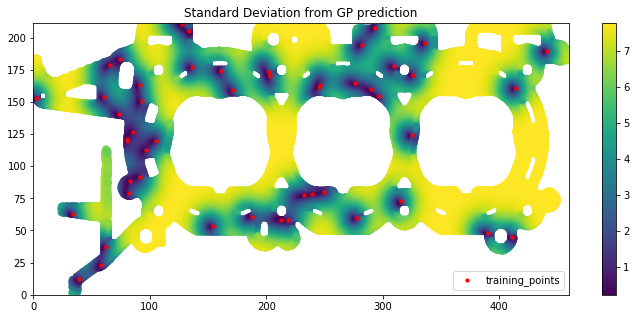

In [5]:
plt.figure(figsize = (12,5))
plt.scatter(X_test[:,0], X_test[:,1], c = std)
plt.colorbar()
plt.scatter(training_points[:,0], training_points[:,1], color = 'red', s = 10, label = 'training_points')
plt.xlim([0, df.X.max()])
plt.ylim([0, df.Y.max()])
plt.title('Standard Deviation from GP prediction')
plt.legend()
plt.show()

#### Next we see how the RMSE varies with the number of training points. Since training data is selected using a RNG, take 10 trials for each training point # and use boxplots.

#### The RMSE decreases almost monotonically with increase in training points.

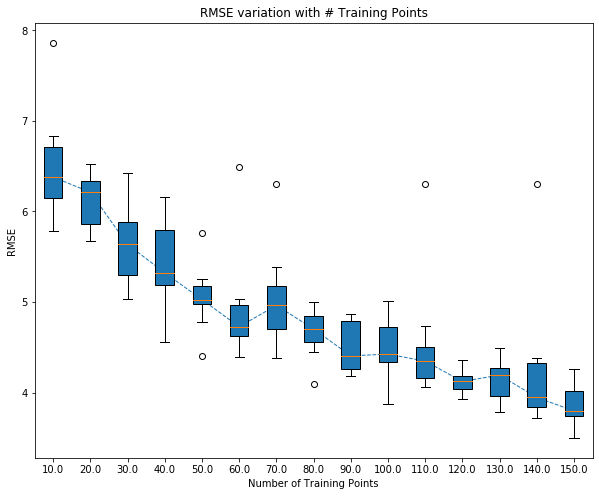

In [6]:
results_dict = {}
n_training_points = np.linspace(10,150,15)
n_trials = 10 #10 trials for each n_training_point
for n_points in n_training_points:
    rmse = []
    for i in range(n_trials):
        training_points, testing_points = getTrainingPoints(df, n_points.astype(int))
        X_train, y_train, X_test, y_test = training_points[:,:-1], training_points[:,-1], testing_points[:,:-1], testing_points[:,-1]
        RMSE, _, _, _ = gaussianProcess(X_train, y_train, X_test, y_test)
        rmse.append(RMSE)
    results_dict[n_points] = rmse
    
plt.figure(figsize = (10,8))
labels, data = results_dict.keys(), results_dict.values()
plt.boxplot(data, patch_artist = True)
plt.plot(range(1, len(n_training_points)+1), np.median(list(results_dict.values()), axis = 1), lw = 1, ls = '--')
plt.xticks(range(1, len(labels) + 1), labels)
plt.xlabel('Number of Training Points')
plt.ylabel('RMSE')
plt.title('RMSE variation with # Training Points')
plt.show()

#### Now we try playing around with different Kernels and see their effect on prediction RMSE.
#### We'll try the inbuilt kernels in scikit-learn. Details available here: https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes

In [10]:
training_points, testing_points = getTrainingPoints(df, 50)
X_train, y_train, X_test, y_test = training_points[:,:-1], training_points[:,-1], testing_points[:,:-1], testing_points[:,-1]
kernel_list = ['RBF', 'Matern', 'Rational Quadratic', 'Periodic','DotProduct']
rmse_dict, params_dict, y_pred_dict, std_dict = {}, {}, {}, {}

for k in kernel_list: 
    rmse_dict[k], params_dict[k], y_pred_dict[k], std_dict[k] = gaussianProcess(X_train, y_train, X_test, y_test, k)
rmse_dict

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


{'RBF': 4.871981475362352,
 'Matern': 4.703017212411419,
 'Rational Quadratic': 4.934144204265872,
 'Periodic': 6.5937750257210705,
 'DotProduct': 6.678604221101434}

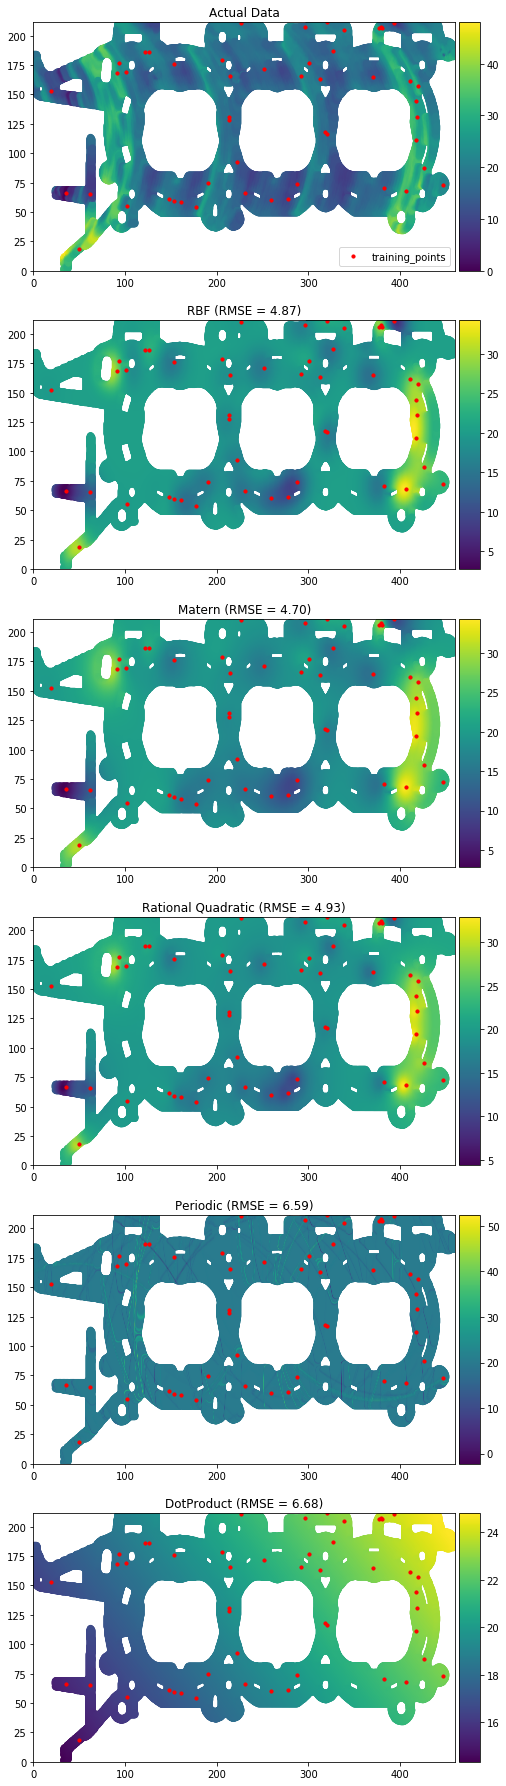

In [11]:
f, axarr = plt.subplots(6,1, figsize = (8, 32))

ax = axarr[0]
z = ax.scatter(X_test[:,0], X_test[:,1], c = y_test)
add_colorbar(z)
ax.scatter(training_points[:,0], training_points[:,1], color = 'red', s = 10, label = 'training_points')
ax.set_xlim([0, df.X.max()])
ax.set_ylim([0, df.Y.max()])
ax.set_title('Actual Data')
ax.legend()

for i in range(1,6):
    ax = axarr[i]
    z = ax.scatter(X_test[:,0], X_test[:,1], c = y_pred_dict[kernel_list[i-1]])
    add_colorbar(z)
    ax.scatter(training_points[:,0], training_points[:,1], color = 'red', s = 10, label = 'training_points')
    ax.set_xlim([0, df.X.max()])
    ax.set_ylim([0, df.Y.max()])
    ax.set_title(kernel_list[i-1] + ' (RMSE = {:.2f})'.format(rmse_dict[kernel_list[i-1]]))
plt.show()

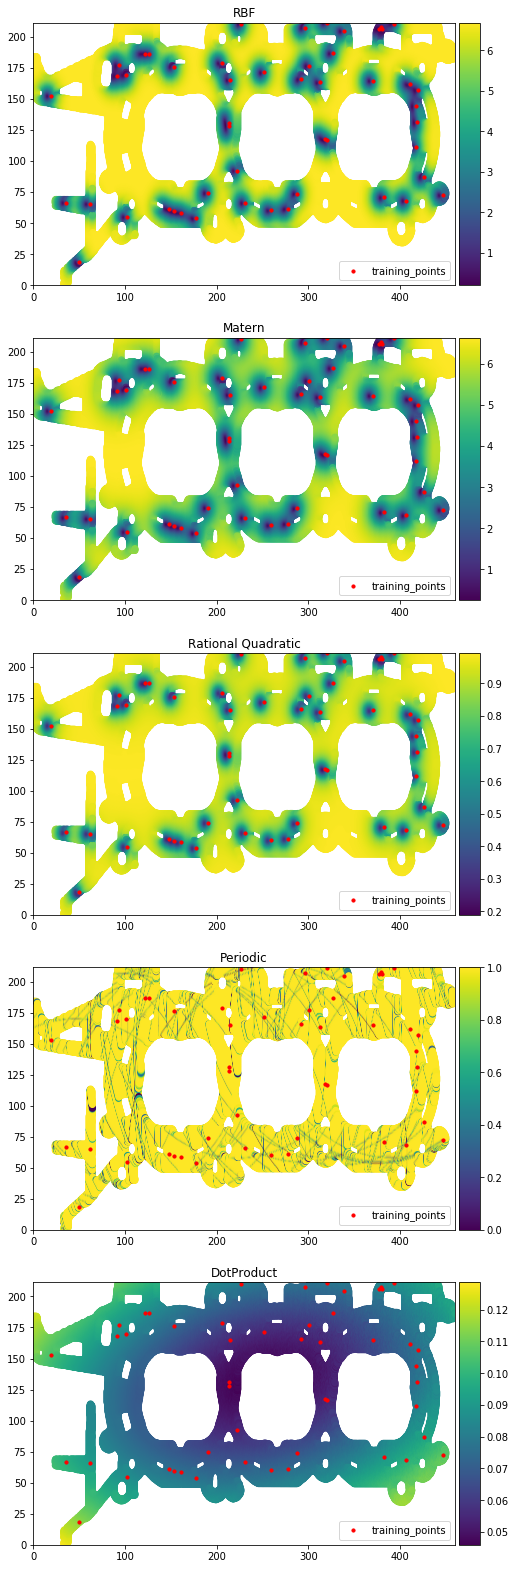

In [12]:
f, axarr = plt.subplots(5,1, figsize = (8, 28))

for i in range(5):
    ax = axarr[i]
    z = ax.scatter(X_test[:,0], X_test[:,1], c = std_dict[kernel_list[i]])
    add_colorbar(z)
    ax.scatter(training_points[:,0], training_points[:,1], color = 'red', s = 10, label = 'training_points')
    ax.set_xlim([0, df.X.max()])
    ax.set_ylim([0, df.Y.max()])
    ax.set_title(kernel_list[i])
    ax.legend()
plt.show()

#### Some observations and questions:
1. The Matern kernel most times performed (slightly) better than others w.r.t. RMSE. Probably because it is a generalized version of RBF and thus hyperparameter tuning gives more control over smoothing.

2. On average, the Matern, RBF and Rational Quadratic kernels performed equally well w.r.t. RMSE and the Periodic and DotProduct perfomed significantly worse.

3. What is the deal with standard deviations? How and why are they low in the final 3 plots?

4. Which kernel was used in the paper, and does the kernel choice change when we do MTL?

5. Is there a way to visualize priors in 2-D (or n-D) like we can in 1D? Like the priors shown here: https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes
